In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import sys
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

sys.path.append('/openfhe-python/openfhe/')
from openfhe import *

In [2]:
# Step 1: Setup OpenFHE CKKS context and generate keys
def setup_openfhe():
    params = CCParamsCKKSRNS()
    params.SetScalingModSize(40)  # Set the scaling factor for CKKS
    params.SetMultiplicativeDepth(3)  # Set the multiplicative depth
    params.SetSecurityLevel(HEStd_128_classic)
    #params.SetRingDim(2048)
    params.SetScalingTechnique(FIXEDAUTO)
    params.SetBatchSize(1024)
    
    cc = GenCryptoContext(params)  # Generate the CKKS context
    cc.Enable(PKESchemeFeature.PKE)  # Enable public key encryption features
    cc.Enable(PKESchemeFeature.KEYSWITCH)  # Enable key switching
    cc.Enable(PKESchemeFeature.LEVELEDSHE)  # Enable leveled homomorphic encryption
    cc.Enable(PKESchemeFeature.ADVANCEDSHE)  # Enable leveled homomorphic encryption
    cc.Enable (PKESchemeFeature.MULTIPARTY)
    print("Mod size: ",params.GetFirstModSize())
    print("Ring Dim: ",params.GetRingDim())
    return cc

# Step 2: Encrypt input using CKKS
def encrypt_input(cc, public_key, input_data):
    # Create a CKKS packed plaintext from the input data
    plaintext = cc.MakeCKKSPackedPlaintext(input_data)
    # Encrypt the plaintext using the public key
    ciphertext = cc.Encrypt(public_key, plaintext)
    return ciphertext

# Step 3: Decrypt ciphertext back to plaintext (with trimming and handling small imaginary parts)
def decrypt_input(cc, kp1_secret_key, kp2_secret_key, ciphertext, original_size):
    ciphertextPartial1 = cc.MultipartyDecryptLead([ciphertext], kp1_secret_key)
    ciphertextPartial2 = cc.MultipartyDecryptMain([ciphertext], kp2_secret_key)
    partialCiphertextVec = [ciphertextPartial1[0], ciphertextPartial2[0]]
    decrypted_plaintext = cc.MultipartyDecryptFusion(partialCiphertextVec)
    decrypted_values = decrypted_plaintext.GetCKKSPackedValue()
    trimmed_decrypted_values = decrypted_values[:original_size]
    real_decrypted_values = [np.real_if_close(value, tol=1e-9) for value in trimmed_decrypted_values]
    float_decrypted_values = [float(np.real(value)) for value in real_decrypted_values]
    return float_decrypted_values

#key generation
cc=setup_openfhe()

# For Party A
kp1 = cc.KeyGen()
evalMultKey = cc.KeySwitchGen(kp1.secretKey, kp1.secretKey)
cc.EvalSumKeyGen(kp1.secretKey)
evalSumKeys = cc.GetEvalSumKeyMap(kp1.secretKey.GetKeyTag())
cc.EvalAtIndexKeyGen(kp1.secretKey, [3,1,-1,-3])
evalAtIndexKeys=cc.GetEvalAutomorphismKeyMap(kp1.secretKey.GetKeyTag())

# For Party B
kp2 = cc.MultipartyKeyGen(kp1.publicKey)
evalMultKey2 = cc.MultiKeySwitchGen(kp2.secretKey, kp2.secretKey, evalMultKey)

# Combine evaluation multiplication keys from both parties
evalMultAB = cc.MultiAddEvalKeys(evalMultKey, evalMultKey2, kp2.publicKey.GetKeyTag())
evalMultBAB = cc.MultiMultEvalKey(kp2.secretKey, evalMultAB, kp2.publicKey.GetKeyTag())

# Summation keys for both parties
evalSumKeysB = cc.MultiEvalSumKeyGen(kp2.secretKey, evalSumKeys, kp2.publicKey.GetKeyTag())
evalSumKeysJoin = cc.MultiAddEvalSumKeys(evalSumKeys, evalSumKeysB, kp2.publicKey.GetKeyTag())
cc.InsertEvalSumKey(evalSumKeysJoin)

# Final evaluation multiplication keys from both parties
evalMultAAB = cc.MultiMultEvalKey(kp1.secretKey, evalMultAB, kp2.publicKey.GetKeyTag())
evalMultFinal = cc.MultiAddEvalMultKeys(evalMultAAB, evalMultBAB, evalMultAB.GetKeyTag())

# Insert the final multiplication key
cc.InsertEvalMultKey([evalMultFinal])
evalAtIndexKeysB=cc.MultiEvalAtIndexKeyGen(kp2.secretKey, evalAtIndexKeys, [3,1,-1,-3], kp2.publicKey.GetKeyTag())
evalAtIndexKeysJoin = cc.MultiAddEvalAutomorphismKeys(evalAtIndexKeys, evalAtIndexKeysB, kp2.publicKey.GetKeyTag())
cc.InsertEvalSumKey(evalAtIndexKeysJoin)#its the same function?


# Define two-party bootstrapping function
def two_party_bootstrapping(ciphertext, partyA, partyB, cc):
    # Prepare ciphertext for bootstrapping by stripping c0
    if ciphertext.GetLevel() < 2:
        return ciphertext

    c1 = ciphertext.Clone()
    c1.RemoveElement(0)
    
    # Generate a common random polynomial (a)
    a = cc.IntMPBootRandomElementGen(partyB.publicKey)
    
    # Each party generates its own decryption share
    share1 = cc.IntMPBootDecrypt(partyA.secretKey, c1, a)
    share2 = cc.IntMPBootDecrypt(partyB.secretKey, c1, a)
    
    # Aggregate the decryption shares
    aggregatedShares = cc.IntMPBootAdd([share1, share2])
    
    # Re-encrypt (bootstrap) the ciphertext
    bootstrapped_ciphertext = cc.IntMPBootEncrypt(partyB.publicKey, aggregatedShares, a, ciphertext)
    
    return bootstrapped_ciphertext


Mod size:  60
Ring Dim:  0
Decrypted result: [1.999944224889337, 3.000050086438181, 4.000041494080593, 2.9354640490607115e-05]


In [3]:
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(73)

# Define transformation to resize to 8x8 and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor
])

# Load the MNIST dataset with the new transformation
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Subset the datasets to use only half of the data
train_subset_indices = list(range(len(train_data)))  # Use the first half
test_subset_indices = list(range(len(test_data)))  # Use the first half

print(f"Number of samples in the training subset: {len(train_subset_indices)}")
print(f"Number of samples in the testing subset: {len(test_subset_indices)}")

train_data = torch.utils.data.Subset(train_data, train_subset_indices)
test_data = torch.utils.data.Subset(test_data, test_subset_indices)

def flatten_dataset(dataset):
    inputs = []
    labels = []

    # Use tqdm to add a progress bar
    for img, label in tqdm(dataset, desc="Processing Dataset"):
        # Flatten 8x8 image to 1D array and encrypt
        inputs.append(img.view(-1).tolist())
        labels.append([label])  # Encrypt label

    return inputs, labels  # Return primitive Python lists

# Flatten training and testing datasets with progress bars
flattened_train_inputs, flattened_train_labels = flatten_dataset(train_data)
flattened_test_inputs, flattened_test_labels = flatten_dataset(test_data)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# # Print example shapes
# example_input = flattened_train_inputs[0]  # The first flattened input
# example_label = flattened_train_labels[0]  # The corresponding label

# # Print the example
# print("Flattened Input (1D array):", example_input)  # A list of 64 floats (8x8)
# #print("Shape of Flattened Input:", len(example_input))  # Length: 64
# print("Label:", example_label)


Number of samples in the training subset: 60000
Number of samples in the testing subset: 10000


Processing Dataset: 100%|██████████| 10000/10000 [00:01<00:00, 6364.52it/s]


In [4]:
class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        # Use Conv1d after flattening the 2D image to 1D
        self.conv1 = torch.nn.Conv1d(1, 1, kernel_size=7, stride=3, padding=0)
        # Fully connected layer (from flattened feature map to hidden layer)
        self.fc1 = torch.nn.Linear(260, 10)

    # Forward pass through the network
    def forward(self, x):
        # Flatten the 2D image to 1D (batch_size, 1, 784)
        x = x.view(x.size(0), 1, -1)  # Flatten to 1D with single channel
        x = self.conv1(x)
        # Apply square activation function (x * x)
        x = x * x
        # Flatten the tensor again for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 4 * 260)
        x = self.fc1(x)
        # Apply square activation function again
        return x

# Step 3: Define the training function
def train(model, train_loader, criterion, optimizer, n_epochs=1):
    start_time = time.time()  # Record start time
    model.train()  # Set model to training mode
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()  # Clear the gradients
            output = model(data)   # Forward pass
            loss = criterion(output, target)  # Calculate loss
            loss.backward()  # Backward pass (calculate gradients)
            optimizer.step()  # Update weights
            train_loss += loss.item()  # Accumulate the loss

        # Calculate and print average loss per epoch
        train_loss = train_loss / len(train_loader)
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')
        end_time = time.time()  # Record end time
        
        # Calculate the total time taken
        total_time = end_time - start_time
    print(f"Total time taken for training: {total_time:.2f} seconds")
    
    model.eval()  # Set model to evaluation mode
    return model


Epoch 1: Loss = 0.710412
Epoch 2: Loss = 0.333547
Epoch 3: Loss = 0.313265
Epoch 4: Loss = 0.303864
Epoch 5: Loss = 0.298816
Epoch 6: Loss = 0.295562
Epoch 7: Loss = 0.293312
Epoch 8: Loss = 0.291582
Epoch 9: Loss = 0.289370
Epoch 10: Loss = 0.287952
Epoch 11: Loss = 0.287646
Epoch 12: Loss = 0.285564
Epoch 13: Loss = 0.285886
Epoch 14: Loss = 0.284634
Epoch 15: Loss = 0.283694
Epoch 16: Loss = 0.283896
Epoch 17: Loss = 0.283001
Epoch 18: Loss = 0.282253
Epoch 19: Loss = 0.282206
Epoch 20: Loss = 0.281595
Epoch 21: Loss = 0.280422
Epoch 22: Loss = 0.280729
Epoch 23: Loss = 0.280526
Epoch 24: Loss = 0.280960
Epoch 25: Loss = 0.279874
Epoch 26: Loss = 0.280492
Epoch 27: Loss = 0.280050
Epoch 28: Loss = 0.279899
Epoch 29: Loss = 0.278770
Epoch 30: Loss = 0.278206
Epoch 31: Loss = 0.278367
Epoch 32: Loss = 0.278090
Epoch 33: Loss = 0.278217
Epoch 34: Loss = 0.276843
Epoch 35: Loss = 0.277485
Epoch 36: Loss = 0.276555
Epoch 37: Loss = 0.277284
Epoch 38: Loss = 0.277846
Epoch 39: Loss = 0.27

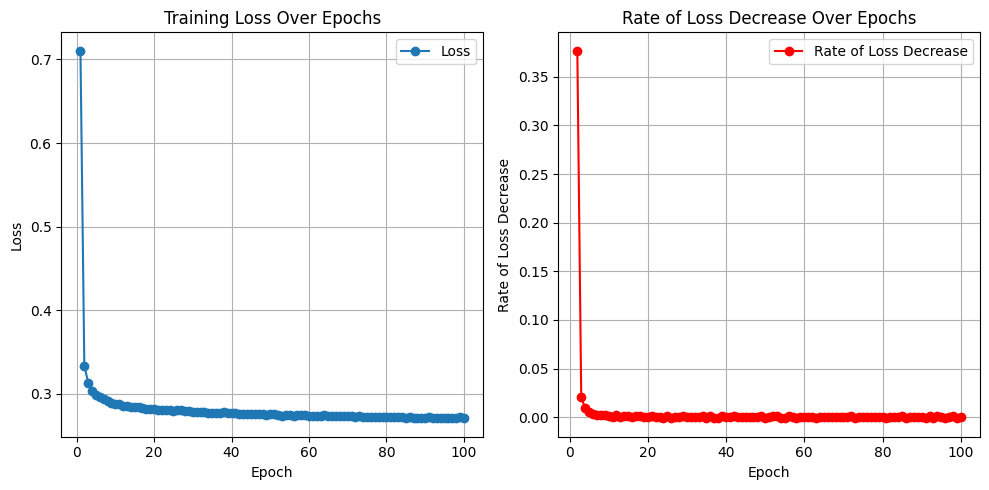

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 260]               8
            Linear-2                   [-1, 10]           2,610
Total params: 2,618
Trainable params: 2,618
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [15]:
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    loss_history = []  # Stores loss for each epoch
    loss_rate = []  # Stores rate of loss decrease

    start_time = time.time()  # Record training start time

    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0.0  # Track loss per epoch
        
        for images, labels in train_loader:  # Iterate through mini-batches
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
        loss_history.append(avg_loss)  # Store loss

        # Compute rate of loss decrease
        if epoch > 1:
            rate = loss_history[-2] - avg_loss
            loss_rate.append(rate)

        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

    end_time = time.time()  # Record training end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    # Plot the loss and rate of loss decrease
    plt.figure(figsize=(10, 5))

    # Loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), loss_history, marker='o', linestyle='-', label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()

    # Rate of loss decrease
    plt.subplot(1, 2, 2)
    plt.plot(range(2, n_epochs + 1), loss_rate, marker='o', linestyle='-', color='r', label="Rate of Loss Decrease")
    plt.xlabel("Epoch")
    plt.ylabel("Rate of Loss Decrease")
    plt.title("Rate of Loss Decrease Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Step 4: Initialize model, loss function, and optimizer
model = ConvNet()  # Instantiate the model
criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Step 5: Train the model and visualize loss trends
model = train(model, train_loader, criterion, optimizer, n_epochs=10)

# Step 6: Display the model architecture using torchsummary
summary(model, input_size=(1, 28, 28))  


In [6]:
def test(model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    start_time = time.time()  # Record start time
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # model in evaluation mode
    model.eval()

    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
    end_time = time.time()  # Record end time
    
    # Calculate the total time taken
    total_time = end_time - start_time
    print(f"Total time taken for training: {total_time:.2f} seconds")
    
test(model, test_loader, criterion)

Test Loss: 0.285902

Test Accuracy of 0: 97% (957/980)
Test Accuracy of 1: 97% (1109/1135)
Test Accuracy of 2: 89% (925/1032)
Test Accuracy of 3: 87% (885/1010)
Test Accuracy of 4: 93% (919/982)
Test Accuracy of 5: 89% (797/892)
Test Accuracy of 6: 95% (917/958)
Test Accuracy of 7: 92% (953/1028)
Test Accuracy of 8: 87% (849/974)
Test Accuracy of 9: 88% (897/1009)

Test Accuracy (Overall): 92% (9208/10000)
Total time taken for training: 1.08 seconds


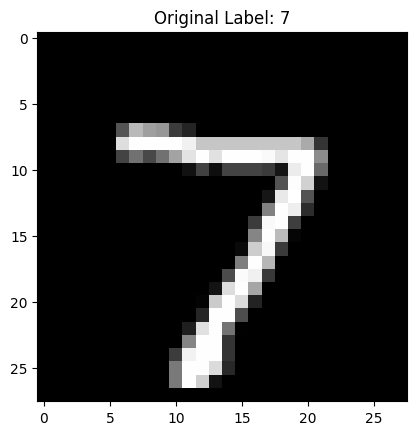

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
Predicted Label: 7
Predicted Probabilities: tensor([[1.6145e-05, 1.6469e-09, 5.5939e-05, 4.0751e-03, 1.1373e-06, 1.0272e-04,
         2.0854e-09, 9.9508e-01, 5.1534e-05, 6.1878e-04]])


In [7]:
import torch
import matplotlib.pyplot as plt

# Function to test the model on a single input
def test_single_image(model, test_loader):
    # Set model to evaluation mode
    model.eval()
    
    # Get a single batch of test images using the next() function
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Select a single image and its label
    img = images[0]
    label = labels[0]
    
    # Display the input image
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.title(f'Original Label: {label}')
    plt.show()
    
    # Add a batch dimension and pass it through the model
    img = img.unsqueeze(0)  # Add batch dimension
    print(img[0][0][0])
    print(img[0][0][1])
    print(img[0][0][2])
    print(img[0][0][3])
    print(img[0][0][4])
    
    with torch.no_grad():  # Disable gradient calculations
        output = model(img)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted label (class with highest probability)
    predicted_label = torch.argmax(probabilities, dim=1).item()
    
    print(f'Predicted Label: {predicted_label}')
    print(f'Predicted Probabilities: {probabilities}')
    
    return predicted_label

# Test the model on a single image
predicted_label = test_single_image(model, test_loader)


In [8]:
conv1_weights = model.conv1.weight.data
conv1_bias = model.conv1.bias.data
print(conv1_bias)
# Print the weights of each filter (mask)
print("Shape of conv1 weights:", conv1_weights.shape)  # Should be [4, 1, 7, 7]
for i, filter_weight in enumerate(conv1_weights):
    print(f"\nFilter {i + 1} (Mask {i + 1}):")
    print(filter_weight.squeeze().numpy())  # Convert to numpy for better readability

tensor([0.6910])
Shape of conv1 weights: torch.Size([1, 1, 7])

Filter 1 (Mask 1):
[ 0.09027265  0.44150528  0.7662245   0.46437865  0.01269974 -0.2455298
 -0.10888661]


In [9]:
def Enc_conv1d(enc_input,enc_kernel,enc_bias,input_length,kernel_length,stride):
    output_length=(input_length-kernel_length)//stride+1
    mask=cc.MakeCKKSPackedPlaintext([1])
    init_result=[0*output_length]
    final_result= encrypt_input(cc, kp2.publicKey, init_result)

    for i in range (output_length):
        result = cc.EvalInnerProduct(enc_input,enc_kernel,kernel_length)
        result = cc.EvalAdd(result,enc_bias)
        result =cc.EvalMult(mask,result)
        final_result=cc.EvalAdd(final_result,result)
        if i<output_length-1:
            enc_input=cc.EvalRotate(enc_input,stride)
            final_result=cc.EvalRotate(final_result,-1)

    decrypted_result=decrypt_input(cc,kp1.secretKey, kp2.secretKey,final_result,output_length)
    reverse_result=decrypted_result[::-1]
    tensor_output = torch.tensor(reverse_result, dtype=torch.float32)
    # Reshape the tensor to match Conv1d output structure
    # Assume Batch Size = 1, Channels = 1, Sequence Length = len(data_list)
    tensor_output = tensor_output.view(1, 1, -1)
    return tensor_output

#print(example_input)
example_input=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
kernel=[0.5, 0.5, 0.5]
bias=[1.0]
input_length=len(example_input)
kernel_length=len(kernel)
encrypted_input= encrypt_input(cc, kp2.publicKey, example_input)
encrypted_kernel= encrypt_input(cc, kp2.publicKey, kernel)
encrypted_bias= encrypt_input(cc, kp2.publicKey, bias)
result=Enc_conv1d(encrypted_input,encrypted_kernel,encrypted_bias,input_length,kernel_length,1)
print(result)


tensor([[[ 4.0000,  5.5000,  7.0000,  8.5000, 10.0000, 11.5000, 13.0000,
          14.5000]]])


In [10]:
class Partial_ConvNet():
    def __init__(self, model, cc, public_key):
        
        super(Partial_ConvNet, self).__init__()  # Call the parent class's constructor
        start_time = time.time()
        # Encrypt weights and biases of conv1
        self.enc_conv1_weights = encrypt_input(cc, public_key, model.conv1.weight.flatten().tolist())
        self.conv1_bias = encrypt_input(cc, public_key, model.conv1.bias.data.flatten().tolist())
        end_time = time.time()  # Record end time
    
        # Calculate the total time taken
        total_time = end_time - start_time
        print(f"Total time taken for encrypting parameter: {total_time:.2f} seconds")
        # Store references to inputs
        self.model = model
        self.cc = cc
        self.public_key = public_key

    def forward(self, x):
        x=Enc_conv1d(x,self.enc_conv1_weights,self.conv1_bias,784,7,3)
        # Apply square activation function (x * x)
        x = x * x
        # Flatten the tensor again for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 4 * 260)
        x = self.model.fc1(x)
        # Apply square activation function again
        return x

    def Enc_conv1d(enc_input,enc_kernel,enc_bias,input_length,kernel_length,stride):
        output_length=(input_length-kernel_length)//stride+1
        print(output_length)
        mask=cc.MakeCKKSPackedPlaintext([1])
        init_result=[0*output_length]
        final_result= encrypt_input(cc, kp2.publicKey, init_result)
    
        for i in range (output_length):
            result = cc.EvalInnerProduct(enc_input,enc_kernel,kernel_length)
            result = cc.EvalAdd(result,enc_bias)
            result =cc.EvalMult(mask,result)
            final_result=cc.EvalAdd(final_result,result)
            if i<output_length-1:
                enc_input=cc.EvalRotate(enc_input,stride)
                final_result=cc.EvalRotate(final_result,-1)
                
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
        decrypted_result=decrypt_input(cc,kp1.secretKey, kp2.secretKey,final_result,output_length)
        reverse_result=decrypted_result[::-1]
        tensor_output = torch.tensor(reverse_result, dtype=torch.float32)
        # Reshape the tensor to match Conv1d output structure
        # Assume Batch Size = 1, Channels = 1, Sequence Length = len(data_list)
        tensor_output = tensor_output.view(1, 1, -1)
        return tensor_output

Enc_ConvNet= Partial_ConvNet(model,cc,kp2.publicKey)




Total time taken for encrypting parameter: 0.02 seconds


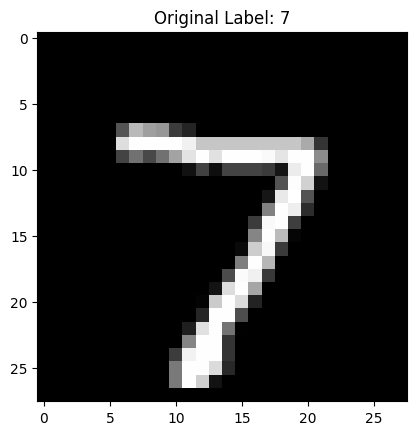

Predicted Label: 7


In [11]:
def test_single_image_enc(test_loader):
    # Set model to evaluation mode
    
    # Get a single batch of test images using the next() function
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    # Select a single image and its label
    img = images[0]
    label = labels[0]
    
    # Display the input image
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.title(f'Original Label: {label}')
    plt.show()
    example_input=img.view(-1).tolist()
    encrypted_input= encrypt_input(cc, kp2.publicKey, example_input)
    with torch.no_grad():  # Disable gradient calculations
        output = Enc_ConvNet(encrypted_input)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted label (class with highest probability)
    predicted_label = torch.argmax(probabilities, dim=1).item()
    
    print(f'Predicted Label: {predicted_label}')
    #print(f'Predicted Probabilities: {probabilities}')
    
    return predicted_label

# Test the model on a single image
predicted_label = test_single_image_enc(test_loader)


In [12]:
def encrypt_test_data(test_loader, cc, public_key):

    encrypted_data = []

    for images, labels in test_loader:
        for i in range(images.size(0)):  # Iterate through each image in the batch
            img = images[i]
            label = labels[i]

            # Flatten the image and encrypt
            example_input = img.view(-1).tolist()
            encrypted_input = encrypt_input(cc, public_key, example_input)
            
            # Append the encrypted image and original label to the list
            encrypted_data.append((encrypted_input, label.item()))

    return encrypted_data


In [13]:
def encrypt_test_data(test_loader, cc, public_key):

    start_time = time.time()  # Start timing
    encrypted_data = []

    print("Encrypting test data...")
    for images, labels in tqdm(test_loader, desc="Encryption Progress"):
        for i in range(images.size(0)):  # Iterate through each image in the batch
            img = images[i]
            label = labels[i]

            # Flatten the image and encrypt
            example_input = img.view(-1).tolist()
            encrypted_input = encrypt_input(cc, public_key, example_input)
            
            # Append the encrypted image and original label to the list
            encrypted_data.append((encrypted_input, label.item()))

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Time to encrypt test data: {elapsed_time:.2f} seconds")
    print(f"Total number of encrypted samples: {len(encrypted_data)}")
    return encrypted_data



def test_encrypted_data(encrypted_data, model, cc):

    start_time = time.time()  # Start timing
    correct_predictions = 0
    total_samples = 0  # Initialize total samples counter

    print("Testing encrypted data...")
    for enc_img, true_label in tqdm(encrypted_data, desc="Testing Progress"):
        total_samples += 1  # Increment total samples

        with torch.no_grad():  # Disable gradient calculations
            output = model(enc_img)

        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Get the predicted label
        predicted_label = torch.argmax(probabilities, dim=1).item()

        # Check if the prediction is correct
        if predicted_label == true_label:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_samples * 100
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Time to test encrypted data: {elapsed_time:.2f} seconds")
    print(f"Accuracy on Encrypted Data: {accuracy:.2f}% ({correct_predictions}/{total_samples})")
    return accuracy


# Encrypt all test cases
encrypted_test_data = encrypt_test_data(test_loader, cc, kp2.publicKey)

# Test the model on the encrypted data
accuracy = test_encrypted_data(encrypted_test_data, Enc_ConvNet, cc)
print(f"Final Accuracy on Encrypted Test Dataset: {accuracy:.2f}%")


Encrypting test data...


Encryption Progress:  28%|██▊       | 44/157 [00:25<01:05,  1.73it/s]


KeyboardInterrupt: 